<center><h1>GAN</h1></center>

<center><h2><a href="https://deepcourse-epita.netlify.app/">Course link</a></h2></center>

To keep your modifications in case you want to come back later to this colab, do *File -> Save a copy in Drive*.

If you find a mistake, or know how to improve this notebook, please open an issue [here](https://gitlab.com/ey_datakalab/course_epita).

We are going to implement a mix of several GAN architecture that work quite well.

It'll be a [DC-GAN](https://arxiv.org/abs/1511.06434) (aka with convolutions), but also a [cGAN](https://arxiv.org/abs/1411.1784) (conditioned on the label of the image to generate), and a [SN-GAN](https://arxiv.org/abs/1802.05957) (with spectral normalization to ease training).

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn.utils.parametrizations import spectral_norm
from torch.nn.utils import spectral_norm
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.utils as vutils
import torchvision
from PIL import Image

Let's load the MNIST dataset. We are going to normalize its pixels to fit in $[-1, +1]$.

In [3]:
transform = transforms.Compose([
  transforms.Resize(32),
  transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])

dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=transform)

loader = DataLoader(dataset, batch_size=128)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:11<00:00, 900kB/s] 


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:06<00:00, 246kB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.07MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



... and visualize!

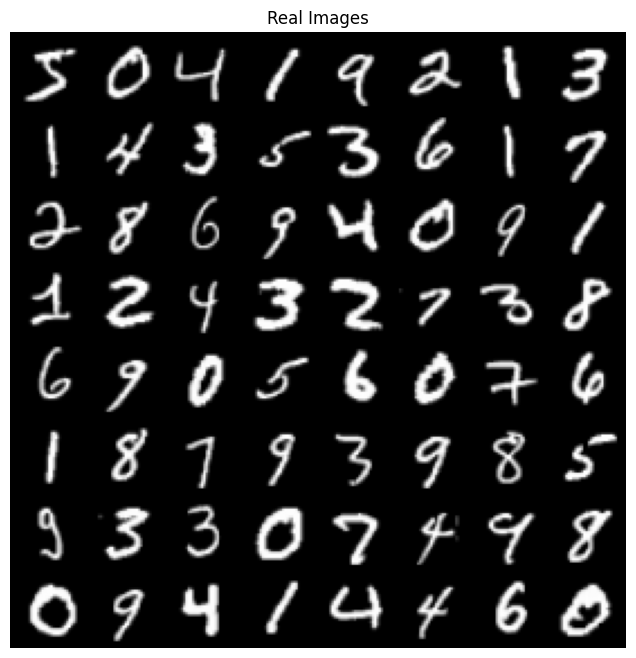

In [4]:
real_batch = next(iter(loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(vutils.make_grid(real_batch[0][:64], normalize=True).permute(1,2,0))
plt.show()

This time, we are going to need a one-hot vector instead of the scalar label. Here is a useful function to get that.

Note the shape of `(10, 10, 1, 1)`:
- The first dimension indicates that we have 10 samples
- The second dimension indicates that we have 10 different classes
- The last two dimensions are added so that our one-hot vector has similar shape as an image `(height, width)`. This is going to be useful later.

In [5]:
def one_hot(y):
  y_onehot = torch.zeros(len(y), 10).to(y.device)
  y_onehot.scatter_(1, y[..., None], 1)
  return y_onehot[..., None, None]

y = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).long()
one_hot_y = one_hot(y)

one_hot_y.squeeze(), one_hot_y.shape

(tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]),
 torch.Size([10, 10, 1, 1]))

Now let's define some hyperparameters.

Adam is a very robust optimizer that can work in many different settings with a wide range of architectures. However, GANs are particularly difficult to optimize and finding the right hyperparameters for Adam can be akin to black magic. Don't hesitate to try to find better ones!



In [6]:
noise_dim = 100
d = 32

lr_d = 0.0002
lr_g = 0.0002
beta_d = (0., 0.9)
beta_g = (0., 0.9)
epsilon_d = 1e-08
epsilon_g = 1e-08

# How many updates of the discriminator to do
# before doing one update of the generator
update_gen_every = 1

# We define lambda functions to create
# the labels for real and fake images
# given a batch size `bs`
REAL = lambda bs: torch.ones(bs)
FAKE = lambda bs: torch.zeros(bs)

Many problems arise with GAN including **mode collapse** where the generator produces the same kind of images or **mode dropping** where the generator fails to produce some details.

The key is that the "battle" between the generator and discriminator isn't too balanced towards one of the models. Otherwise we can see vanishing or exploding gradients for the discriminator, leading to a very bad GAN...

Multiple works have tried to stabilize the training, mainly by enforcing that the discriminator is $K$-Lipschitz (~that its loss is smooth). The most famous paper about that is probably the [Wasserstein GAN](https://arxiv.org/abs/1701.07875). However we are going to implement the [Spectral Normalization (SN) GAN](https://arxiv.org/abs/1802.05957) which is simpler and more efficient.


Spectral Normalization is very simple, the weights are divided by its maximum singular value. Thus the weight is 1-Lipschitz:

$$\mathbf{W}_{S N}=\frac{\mathbf{W}}{\sigma(\mathbf{W})}, \sigma(\mathbf{W})=\max _{\mathbf{h}: \mathbf{h} \neq 0} \frac{\|\mathbf{W h}\|_{2}}{\|\mathbf{h}\|_{2}}$$

We simply need to wrap the discriminator's Conv layers (and FC layers if we had some) with PyTorch's `spectral_norm`.

In [7]:
class SpectralConv(nn.Module):
  def __init__(self, *args, **kwargs):
    super().__init__()
    self.conv = spectral_norm(nn.Conv2d(*args, **kwargs))

  def forward(self, x):
    return self.conv(x)


# When defining the discriminator AND generator
# instead of using BatchNorm use the variable `norm_layer`
# so you can try easily BatchNorm vs InstanceNorm
# More on it here:
# * https://arthurdouillard.com/post/normalization/

# For the discriminator replace all Conv by `conv_disc_layer`
# so you can try easily between a classic Conv and a Spectral Conv.

norm_layer = nn.InstanceNorm2d  # nn.BatchNorm2d
conv_disc_layer = SpectralConv # nn.Conv2d

First, define the discriminator, which will takes in input both real and fake images and must decide which one is real. Note that the number of channels will be a multiple of $d$ which was defaulted in a previous cell to $32$.

For the discriminator only, we also replace all ReLUs by Leaky ReLUs to avoid dying neurons:

$$\text { LeakyRELU }(x)=\left\{\begin{array}{ll}
x, & \text { if } x \geq 0 \\
\text { negative_slope } \times x, & \text { otherwise }
\end{array}\right.$$

Define three branches:

**Image branch**: takes (real or fake) image in input
- one `conv_disc_layer` that produces $2d$ channels, $4\times 4$ kernel, stride $2$, and padding $1$
- One LeakyReLU with a slope of $0.2$.

**Label branch**: takes the one-hot label in input
- one `conv_disc_layer` that produces $2d$ channels, $4\times 4$ kernel, stride $2$, and padding $1$
- One LeakyReLU with a slope of $0.2$.

The output of those two branches will be concatenated and given to the **classifier branch** that produces the binary classification real-vs-fake:
- one `conv_disc_layer` that produces $8d$ channels, $4\times 4$ kernel, stride $2$, and padding $1$
- one `norm_layer`
- One LeakyReLU with a slope of $0.2$
- one `conv_disc_layer` that produces $16d$ channels, $4\times 4$ kernel, stride $2$, and padding $1$
- one `norm_layer`
- One LeakyReLU with a slope of $0.2$
- one `conv_disc_layer` that produces $1$ channels, $4\times 4$ kernel, stride $2$, and padding $1$
- one sigmoid

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.img_branch = nn.Sequential(
            conv_disc_layer(1, d * 2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.label_branch = nn.Sequential(
            conv_disc_layer(10, d * 2, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.classifier = nn.Sequential(
            conv_disc_layer(d * 4, d * 8, 4, 2, 1, bias=False),
            norm_layer(d * 8),
            nn.LeakyReLU(0.2, inplace=True),
            conv_disc_layer(d * 8, d * 16, 4, 2, 1, bias=False),
            norm_layer(d * 16),
            nn.LeakyReLU(0.2, inplace=True),
            conv_disc_layer(d * 16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        # Expand label to have the size of the image
        y = y.expand(y.shape[0], y.shape[1], x.shape[2], x.shape[3])

        x = self.img_branch(x)
        y = self.label_branch(y)

        xy_concatenated = torch.cat([x, y], dim=1)
        o = self.classifier(xy_concatenated)

        return o.squeeze() # go from (bs, 1, 1, 1) to (bs,)


Discriminator()(torch.randn(10, 1, 32, 32), one_hot(y)).shape

torch.Size([10])

In [9]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://deepcourse-epita.netlify.app/code/gan/disc.py
%pycat disc.py

--2024-11-08 09:06:18--  https://deepcourse-epita.netlify.app/code/gan/disc.py
Resolving deepcourse-epita.netlify.app (deepcourse-epita.netlify.app)... 52.74.232.59, 52.220.155.145, 2406:da18:b3d:e200::65, ...
Connecting to deepcourse-epita.netlify.app (deepcourse-epita.netlify.app)|52.74.232.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1260 (1.2K) [text/x-python]
Saving to: ‘disc.py’

disc.py             100%[===================>]   1.23K  --.-KB/s    in 0s      

2024-11-08 09:06:19 (29.2 MB/s) - ‘disc.py’ saved [1260/1260]



Now let's build the generator. Again we use the `norm_layer` variable for our normalization layer, however we aren't going to use the `conv_disc_layer` but instead of `nn.ConvTranspose2d` to "upsample" the image:

```
nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0
```

Again, three branches:

**Noise branch**: that takes in input the noise vector:
- A ConvTranspose with $8d$ channels, a $4\times 4$ kernel, stride $1$, padding $0$
- a `norm_layer`
- a ReLU

**Label branch**: that takes the label in input:
- A ConvTranspose with $8d$ channels, a $4\times 4$ kernel, stride $1$, padding $0$
- a `norm_layer`
- a ReLU

The output of those two branches will be concatenated and given to the **generator branch** that produces the fake image:
- A ConvTranspose with $8d$ channels, a $4\times 4$ kernel, stride $2$, padding $0$
- a `norm_layer`
- a ReLU
- A ConvTranspose with $4d$ channels, a $4\times 4$ kernel, stride $2$, padding $0$
- a `norm_layer`
- a ReLU
- A ConvTranspose with $1$ channels, a $4\times 4$ kernel, stride $2$, padding $0$
- a Tanh


In [12]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.noise_branch = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, d * 8, kernel_size=4, stride=1, padding=0, bias=False),
            norm_layer(d * 8),
            nn.ReLU(True)
        )
        self.label_branch = nn.Sequential(
            nn.ConvTranspose2d(10, d * 8, 4, 1, 0, bias=False),
            norm_layer(d * 8),
            nn.ReLU(True)
        )
        self.generator = nn.Sequential(
            nn.ConvTranspose2d( d * 16, d * 8, 4, 2, 1, bias=False),
            norm_layer(d * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(d * 8, d * 4, 4, 2, 1, bias=False),
            norm_layer(d * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(d * 4, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z, y):
        z = self.noise_branch(z)
        y = self.label_branch(y)

        zy_concatenated = torch.cat([z, y], dim=1)
        o = self.generator(zy_concatenated)

        return o

Generator()(torch.randn(10, noise_dim, 1, 1), one_hot(y)).shape

torch.Size([10, 1, 32, 32])

In [11]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://deepcourse-epita.netlify.app/code/gan/gen.py
%pycat gen.py

--2024-11-08 09:09:39--  https://deepcourse-epita.netlify.app/code/gan/gen.py
Resolving deepcourse-epita.netlify.app (deepcourse-epita.netlify.app)... 52.74.232.59, 52.220.155.145, 2406:da18:b3d:e200::65, ...
Connecting to deepcourse-epita.netlify.app (deepcourse-epita.netlify.app)|52.74.232.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1124 (1.1K) [text/x-python]
Saving to: ‘gen.py’

gen.py              100%[===================>]   1.10K  --.-KB/s    in 0s      

2024-11-08 09:09:40 (23.0 MB/s) - ‘gen.py’ saved [1124/1124]



Check that the output of the generator has the same dimension as a real image! If not it may lead to unforeseen problems!

In [13]:
real_batch[0].shape

torch.Size([128, 1, 32, 32])

Now let's code our noise generator and criterion:

In [14]:
def sample_z(batch_size):
  return torch.randn(batch_size, noise_dim, 1, 1).cuda()

criterion = nn.BCELoss()

For simplicity, we code a forward pass in a separate function that we call `train_on_batch`.

In [15]:
def train_on_batch(x_real, y_real, G, D, opt_g, opt_d, n_iter, update_gen_every=5):
    opt_g.zero_grad()
    opt_d.zero_grad()

    real = REAL(len(x_real)).cuda()
    fake = FAKE(len(x_real)).cuda()

    # --------------
    # First, train G
    # --------------
    z = sample_z(x_real.size(0))
    x_fake = G(z, y_real)
    g_loss = criterion(D(x_fake, y_real), real)

    if n_iter % update_gen_every == 0:
      # This backpropagates from the output of D, all the
      # way back into G.
      g_loss.backward()
      # G's gradient buffers are filled, we can perform
      # an optimisation step.
      opt_g.step()
    x_fake = x_fake.detach()

    # ------------
    # Now, train D
    # ------------

    # IMPORTANT: D's grad buffers are filled because
    # of what we did above.
    opt_d.zero_grad()

    d_loss = criterion(D(x_fake, y_real), fake) + \
             criterion(D(x_real, y_real), real)
    d_loss.backward()
    opt_d.step()

    return g_loss.detach(), d_loss.detach()


We fix a noise vector that we will monitor to see how well our model fares.

In [16]:
fixed_noise = sample_z(20).cuda()
fixed_y = one_hot(torch.cat((
    torch.arange(10), torch.arange(10)
))).cuda()

Let's train!

--- Epoch 0 ---


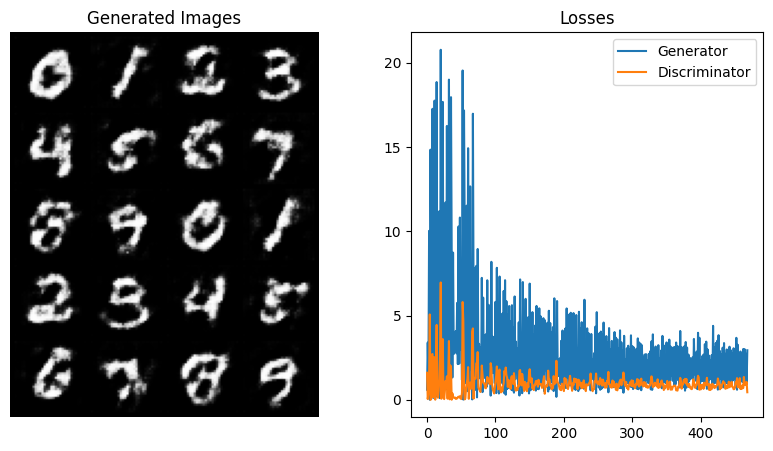

--- Epoch 1 ---


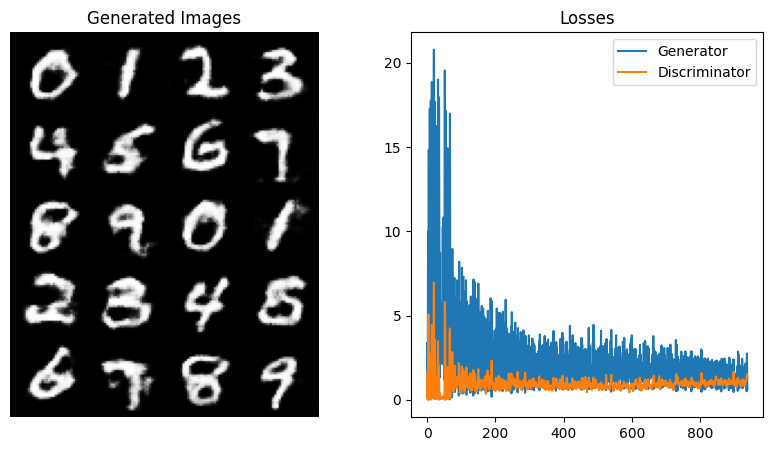

--- Epoch 2 ---


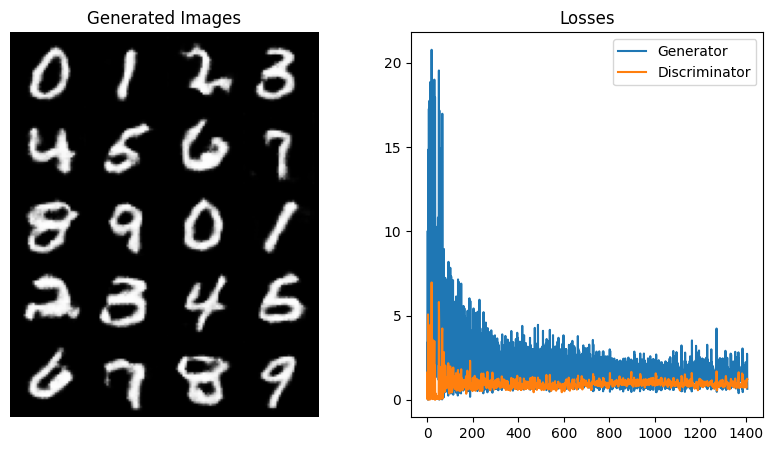

--- Epoch 3 ---


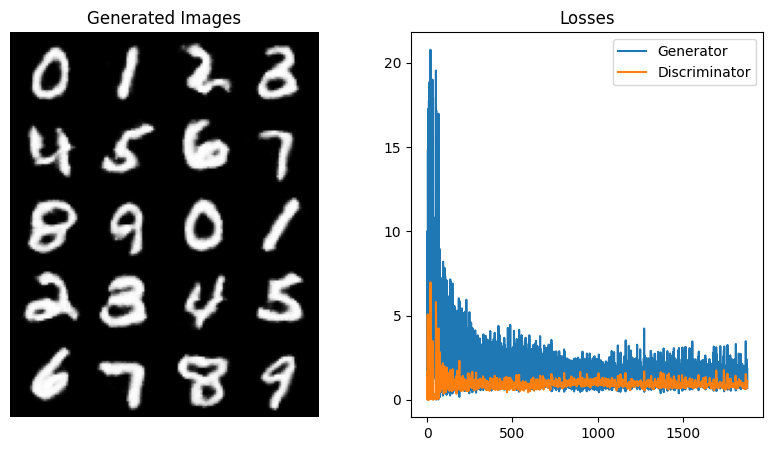

--- Epoch 4 ---


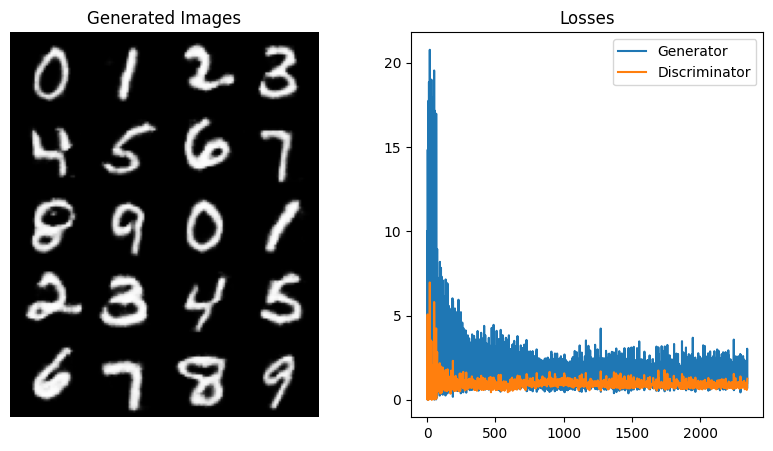

In [17]:
epochs = 5
n_iter = 0


G = Generator().cuda()
D = Discriminator().cuda()

def normal_init(m, mean=0.0, std=0.02):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)

G.apply(normal_init)
D.apply(normal_init)

opt_g = torch.optim.Adam(G.parameters(), lr=lr_g, betas=beta_g, eps=1e-08)
opt_d = torch.optim.Adam(D.parameters(), lr=lr_d, betas=beta_d, eps=1e-08)

losses_g, losses_d = [], []
gen_imgs = []

for epoch in range(epochs):
  if epoch in (12, 16):
    opt_g.param_groups[0]['lr'] /= 10
    opt_d.param_groups[0]['lr'] /= 10

  for x, y in loader:
    x = x.cuda()
    y = one_hot(y).cuda()

    loss_g, loss_d = train_on_batch(x, y, G, D, opt_g, opt_d, n_iter, update_gen_every)
    losses_g.append(loss_g.cpu().numpy())
    losses_d.append(loss_d.cpu().numpy())

    n_iter += 1

  print(f"--- Epoch {epoch} ---")
  with torch.no_grad():
    x_fake = G(fixed_noise, fixed_y).cpu()

  gen_imgs.append(vutils.make_grid(x_fake, normalize=True, nrow=4).permute(1, 2, 0))

  f, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes[0].imshow(gen_imgs[-1])
  axes[0].axis('off')
  axes[0].set_title("Generated Images")

  indexes = np.arange(len(losses_g))
  axes[1].plot(indexes, losses_g, label="Generator")
  axes[1].plot(indexes, losses_d, label="Discriminator")
  axes[1].set_title("Losses")
  axes[1].legend(loc="best")

  f.show()
  plt.pause(0.5)


In [18]:
import imageio


imageio.mimsave('mnist.gif', [(255 * img.cpu().numpy()).astype(np.uint8) for img in gen_imgs])